In [1]:
import glob
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from matplotlib import rcParams
import matplotlib.pyplot as plt

rcParams["legend.fontsize"] = 11
rcParams["legend.labelspacing"] = 0.2
rcParams["hatch.linewidth"] = 0.5
rcParams["axes.xmargin"] = 0.0  # rootlike, no extra padding within x axis
rcParams["axes.labelsize"] = "x-large"
rcParams["axes.formatter.use_mathtext"] = True
rcParams["legend.framealpha"] = 0.65
rcParams["axes.labelsize"] = "x-large"
rcParams["axes.titlesize"] = "large"
rcParams["xtick.labelsize"] = "large"
rcParams["ytick.labelsize"] = "large"
rcParams["figure.subplot.hspace"] = 0.1
rcParams["figure.subplot.wspace"] = 0.1
rcParams["figure.subplot.right"] = 0.96
rcParams["figure.max_open_warning"] = 0
rcParams["figure.dpi"] = 100
rcParams["axes.formatter.limits"] = [-5, 4]

In [2]:
reports_file = "../hadoop_reports/phedex/phedex_reports_04-13-2021.txt.gz"
chunk_dir = "../hadoop_reports/phedex/parquet_chunks"

os.makedirs(chunk_dir, exist_ok=True)
if len(glob.glob(f"{chunk_dir}/*.parquet")) == 0:
    df_chunks = pd.read_csv(
        reports_file, 
        header=None, 
        delim_whitespace=True, 
        chunksize=200000, 
        error_bad_lines=False,
        warn_bad_lines=False
    )
    for i, df_chunk in tqdm(enumerate(df_chunks)):
        # Set columns for each chunk (these are space-separated output of hdfs dfs -ls -R /cms/store/...)
        df_chunk.columns = ["junk1", "junk2", "junk3", "user", "bytes", "date", "junk4", "ext"]
        # Select only the interesting columns
        df_chunk = df_chunk.reset_index(drop=True)[["user","bytes","date","ext"]]
        # Drop files w/ bytes == 0 (these are directories)
        df_chunk = df_chunk[df_chunk["bytes"] > 0]
        # Grab the file extensions specfically
        df_chunk["ext"] = df_chunk["ext"].str.rsplit(".", 1).str[-1]
        df_chunk = df_chunk.reset_index(drop=True)
        # Translate string dates to datetime objects (more space efficient)
        df_chunk["date"] = pd.to_datetime(df_chunk["date"])
        # Translate remaining string columns to categoricals (more space efficient)
        df_chunk["ext"] = df_chunk["ext"].astype("category")
        df_chunk["user"] = df_chunk["user"].astype("category")
        # Save chunk to a parquet file
        df_chunk.to_parquet(f"{chunk_dir}/chunk_{i:04d}.parquet")

# Recursively read all parquet_files and concat them, preserving categoricals
df = pd.read_parquet(chunk_dir)
# Make all extensions lowercase
df["ext"] = df.ext.str.lower().astype("category")

In [3]:
all_counts = df.groupby("ext")["bytes"].count()
all_sizes = df.groupby("ext")["bytes"].sum()

In [20]:
top_by_size = all_sizes.nlargest(4)

sizes = list(top_by_size.values)
extensions = list(top_by_size.index.values)
counts = []

print("Ext".ljust(10), "Size".rjust(11), "Count".rjust(10))
print("---------------------------------")
for i in range(len(sizes)):
    size = sizes[i]
    ext = extensions[i]
    count = all_counts[ext]
    counts.append(count)
    print(("."+ext).ljust(10), "{:.3f} TB".format(size/1e12).rjust(11), end=" ")
    print("{:10d}".format(count))
print("---------------------------------")
print(
    "OTHER".ljust(10), 
    "{:.3f} TB".format((np.sum(df.bytes) - np.sum(sizes))/1e12).rjust(11),
    "{:10d}".format(np.sum(all_counts) - np.sum(counts))
)
print(
    "TOTAL".ljust(10), 
    "{:.3f} TB".format(np.sum(df.bytes)/1e12).rjust(11),
    "{:10d}".format(np.sum(all_counts))
)

Ext               Size      Count
---------------------------------
.root      1155.019 TB     506030
.gz           1.716 TB     222812
.corrupt      1.229 TB        273
.file0000     0.024 TB         88
---------------------------------
OTHER         4.774 TB       1860
TOTAL      1162.762 TB     731063


In [29]:
top_by_count = all_counts.nlargest(6)

sizes = []
extensions = list(top_by_count.index.values)
counts = list(top_by_count.values)

print("Ext".ljust(10), "Count".rjust(10), "Size".rjust(11))
print("---------------------------------")
for i in range(len(counts)):
    count = counts[i]
    ext = extensions[i]
    size = all_sizes[ext]
    sizes.append(size)
    print(("."+ext).ljust(10), "{:10d}".format(count), end=" ")
    print("{:.3f} TB".format(size/1e12).rjust(11))
print("---------------------------------")
print(
    "OTHER".ljust(10), 
    "{:10d}".format(np.sum(all_counts) - np.sum(counts)),
    "{:.3f} TB".format((np.sum(df.bytes) - np.sum(sizes))/1e12).rjust(11)
)
print(
    "TOTAL".ljust(10),
    "{:10d}".format(np.sum(all_counts)),
    "{:.3f} TB".format(np.sum(df.bytes)/1e12).rjust(11)
)

Ext             Count        Size
---------------------------------
.root          506030 1155.019 TB
.gz            222812    1.716 TB
.corrupt          273    1.229 TB
.file0000          88    0.024 TB
.file0001          10    0.003 TB
.txt                8    0.000 TB
---------------------------------
OTHER            1842    4.771 TB
TOTAL          731063 1162.762 TB


In [6]:
BINS = [
    0.1, 1, 10, 1e2, 
    1e3, 1e4, 1e5, 
    1e6, 1e7, 1e8, 
    1e9, 1e10, 1e11, 
    1e12, 1e13
]
LABELS = [
    "0B", "1B", "10B", "100B", 
    "1KB", "10KB", "100KB", 
    "1MB", "10MB", "100MB",
    "1GB", "10GB", "100GB",
    "1TB", "10TB"
]
HADOOP_PATH = "cms/phedex/store"

BYTES_LOOKUP = dict(zip(LABELS, BINS))

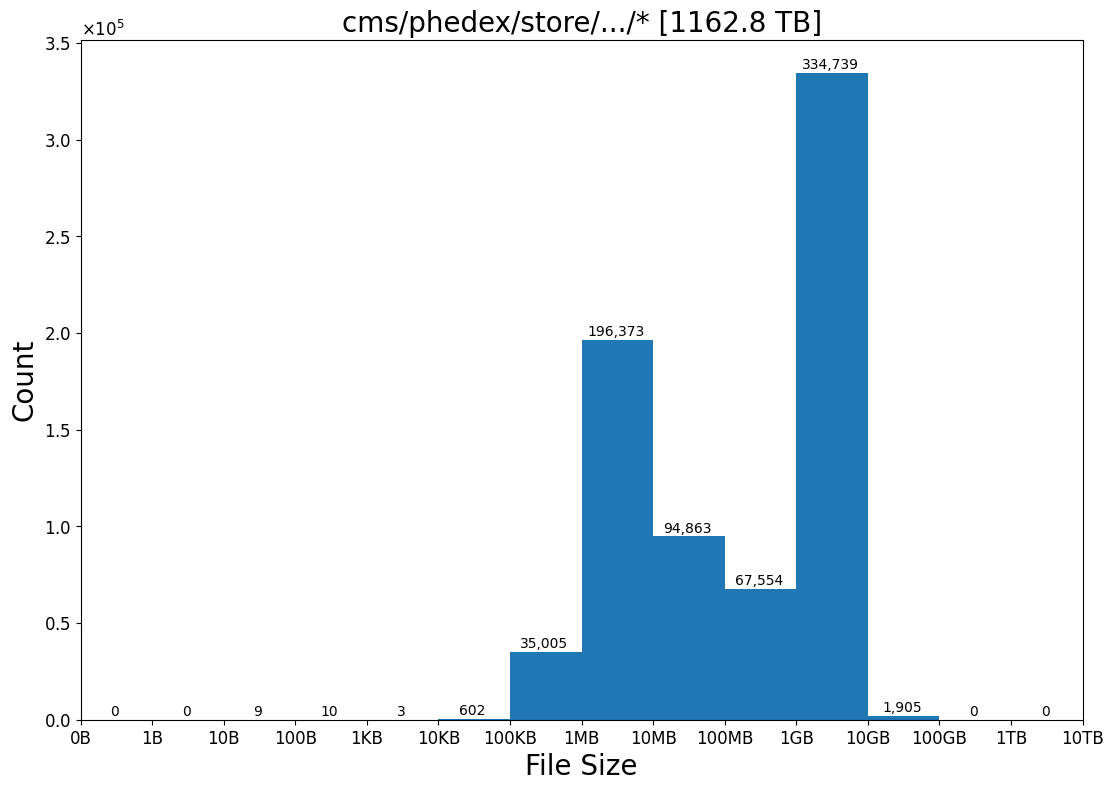

In [7]:
fig, axes = plt.subplots(figsize=(12, 9))

counts, bin_edges, _ = axes.hist(df.bytes, bins=BINS);
axes.set_xscale("log");
axes.set_xticks(BINS);
axes.set_xticklabels(LABELS)

axes.set_ylabel("Count", size=20);
axes.set_xlabel("File Size", size=20);

plt.title("{0}/.../* [{1:.1f} TB]".format(HADOOP_PATH, np.sum(df.bytes)/1e12), size=20);

label_locs = bin_edges[:-1]*3
for i, count in enumerate(counts.astype(int)):
    plt.text(label_locs[i], count+2e3, "{:,d}".format(count), horizontalalignment='center')

Bucket     Count   Count%
-------------------------
< 1B           0    0.00%
< 10B          0    0.00%
< 100B         9    0.00%
< 1KB         10    0.00%
< 10KB         3    0.00%
< 100KB      602    0.08%
< 1MB      35005    4.79%
< 10MB    196373   26.86%
< 100MB    94863   12.98%
< 1GB      67554    9.24%
< 10GB    334739   45.79%
< 100GB     1905    0.26%
< 1TB          0    0.00%
< 10TB         0    0.00%
-------------------------
TOTAL     731063  100.00%


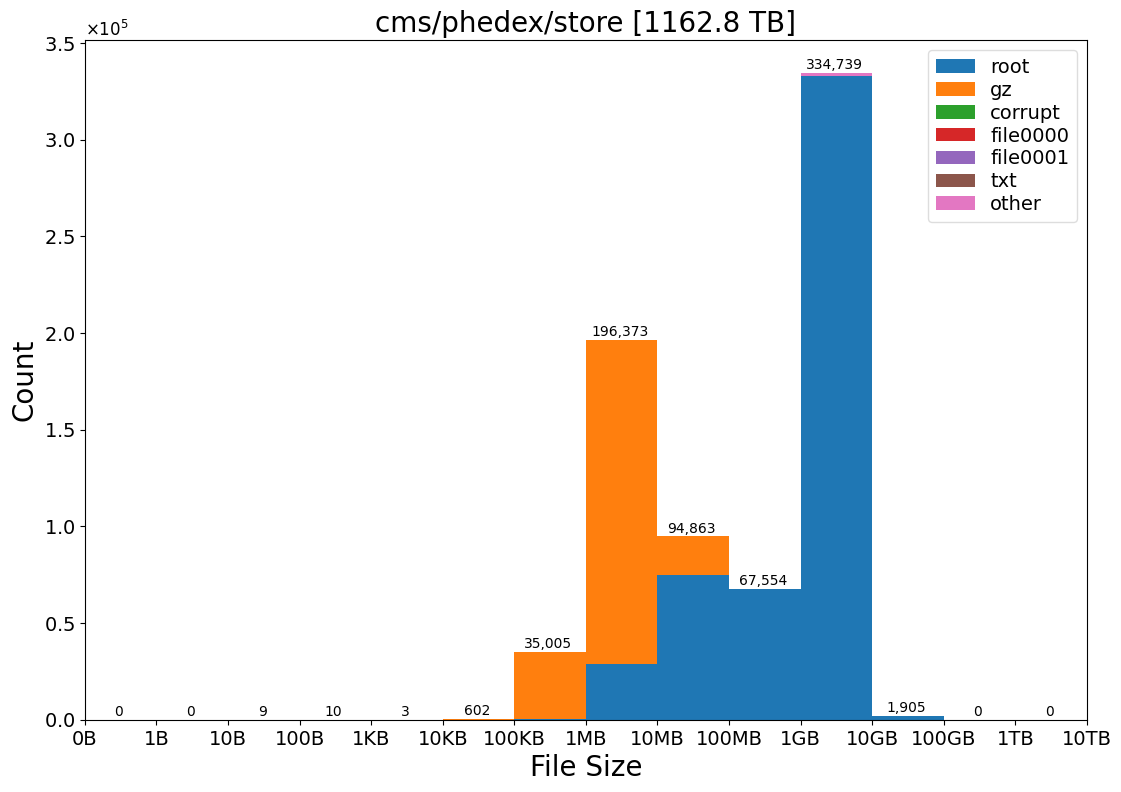

In [8]:
fig, axes = plt.subplots(figsize=(12, 9))
plt.tick_params(labelsize=14)

file_types = list((df.groupby("ext").bytes.count()).nlargest(6).index.values)
counts, bin_edges, _ = axes.hist(
    [df[df.ext == e].bytes for e in file_types]+[df[~df.ext.isin(file_types)].bytes], 
    stacked=True,
    bins=BINS,
    label=file_types+["other"]
);
axes.legend(fontsize=14);
axes.set_xscale("log");
axes.set_xticks(BINS);
axes.set_xticklabels(LABELS);

axes.set_ylabel(r"Count", size=20);
axes.set_xlabel("File Size", size=20);

plt.title("{0} [{1:.1f} TB]".format(HADOOP_PATH, np.sum(df.bytes)/1e12), size=20);

total_counts = counts[-1].astype(int)
total = np.sum(total_counts)
print("Bucket".ljust(8), "Count".rjust(7), end=" ")
print("Count%".rjust(8))
print("-------------------------")
for i, count in enumerate(total_counts):
    print(
        "< {}".format(LABELS[i+1]).ljust(8), 
        "{:7d}".format(count),
        end=" "
    )
    print("{:.2f}%".format(count/total*100).rjust(8))
print("-------------------------")
print("TOTAL".ljust(8), "{:7d}".format(total), end=" ")
print("100.00%".rjust(8))

label_locs = bin_edges[:-1]*3
for i, count in enumerate(total_counts):
    plt.text(label_locs[i], count+2e3, "{:,d}".format(count), horizontalalignment='center')

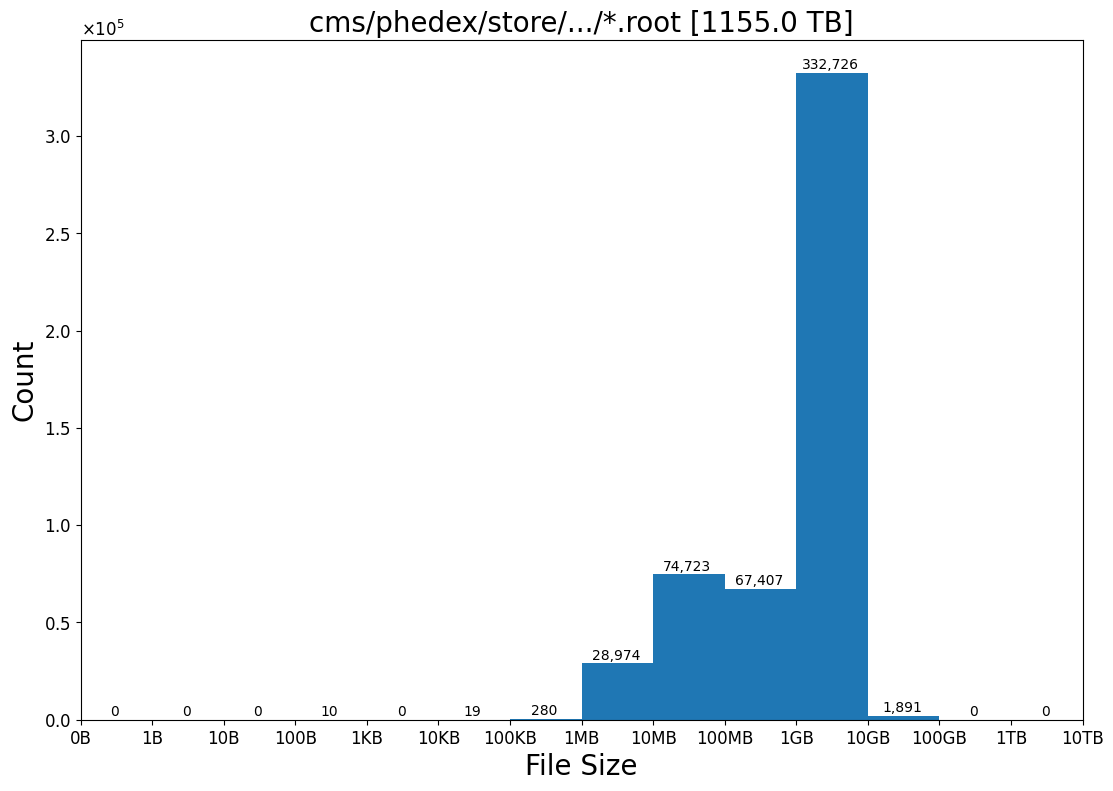

In [9]:
fig, axes = plt.subplots(figsize=(12, 9))

counts, bin_edges, _ = axes.hist(df[df.ext == "root"].bytes, bins=BINS);
axes.set_xscale("log");
axes.set_xticks(BINS);
axes.set_xticklabels(LABELS)

axes.set_ylabel("Count", size=20);
axes.set_xlabel("File Size", size=20);

plt.title("{0}/.../*.root [{1:.1f} TB]".format(HADOOP_PATH, np.sum(df[df.ext == "root"].bytes)/1e12), size=20);

label_locs = bin_edges[:-1]*3
for i, count in enumerate(counts.astype(int)):
    plt.text(label_locs[i], count+2e3, "{:,d}".format(count), horizontalalignment='center')

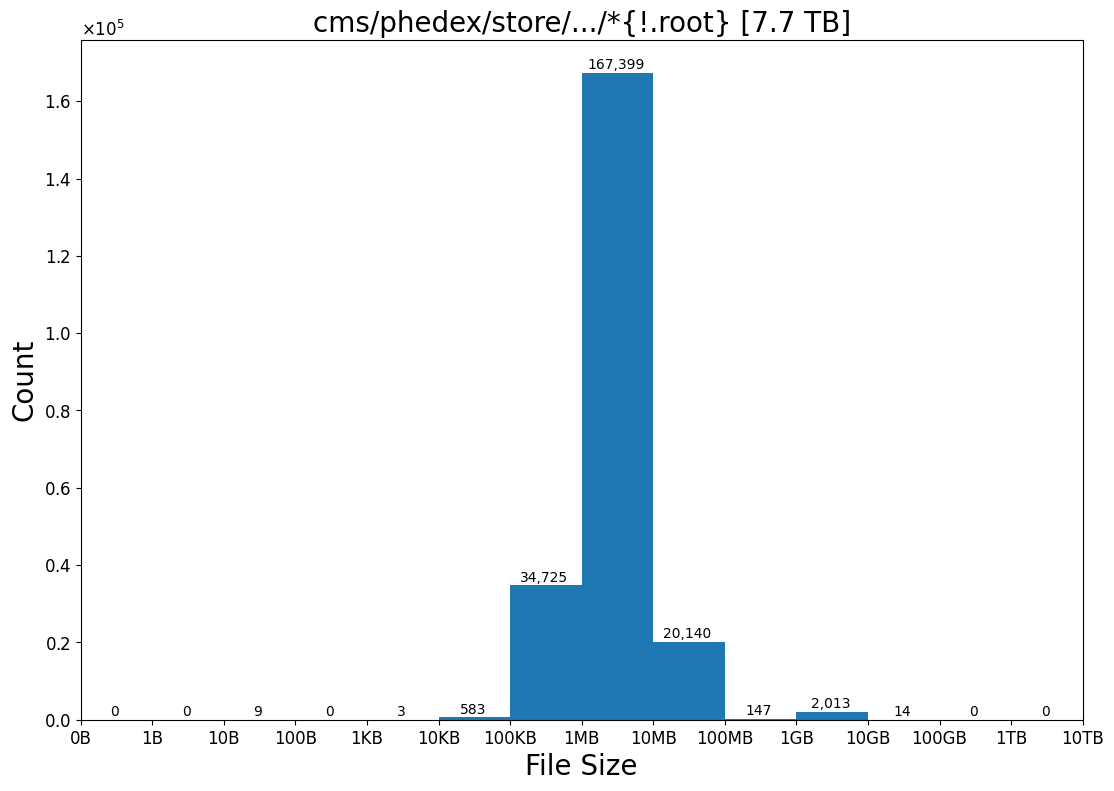

In [10]:
fig, axes = plt.subplots(figsize=(12, 9))

counts, bin_edges, _ = axes.hist(df[df.ext != "root"].bytes, bins=BINS);
axes.set_xscale("log");
axes.set_xticks(BINS);
axes.set_xticklabels(LABELS)

axes.set_ylabel("Count", size=20);
axes.set_xlabel("File Size", size=20);

plt.title("{0}/.../*{{!.root}} [{1:.1f} TB]".format(HADOOP_PATH, np.sum(df[df.ext != "root"].bytes)/1e12), size=20);

label_locs = bin_edges[:-1]*3
for i, count in enumerate(counts.astype(int)):
    plt.text(label_locs[i], count+1e3, "{:,d}".format(count), horizontalalignment='center')

In [11]:
(df[(df.ext != "root") & (df.bytes > BYTES_LOOKUP["1GB"])].groupby("ext")["bytes"].sum()/1e12).nlargest(10)

ext
corrupt                                         1.225171
/cms/phedex/store/test/letts/file_1594321781    0.004733
/cms/phedex/store/test/letts/file_1594322385    0.004733
/cms/phedex/store/test/letts/file_1594322699    0.004733
/cms/phedex/store/test/letts/file_1594323013    0.004733
/cms/phedex/store/test/letts/file_1594323326    0.004733
/cms/phedex/store/test/letts/file_1594323640    0.004733
/cms/phedex/store/test/letts/file_1594323953    0.004733
/cms/phedex/store/test/letts/file_1594324267    0.004733
/cms/phedex/store/test/letts/file_1594324580    0.004733
Name: bytes, dtype: float64

In [14]:
bins = [
    1*1e0, 10*1e0, 100*1e0, # b
    1*1e3, 10*1e3, 100*1e3, # kb
    1*1e6, 10*1e6, 100*1e6, # mb
    1*1e9, 10*1e9, 100*1e9, # gb
    1*1e12, 10*1e12, # tb
]

def num_to_human(num, rjust=5):
    if num < 1000**1:   
        return f"{int(num/1000**0)}B".rjust(rjust)
    elif num < 1000**2:   
        return f"{int(num/1000**1)}KB".rjust(rjust)
    elif num < 1000**3:   
        return f"{int(num/1000**2)}MB".rjust(rjust)
    elif num < 1000**4:   
        return f"{int(num/1000**3)}GB".rjust(rjust)
    elif num < 1000**5:   
        return f"{int(num/1000**4)}TB".rjust(rjust)
    else:
        return num

def interval_to_human(interval):
    left = num_to_human(interval.left, rjust=0)
    right = num_to_human(interval.right, rjust=0)
    return f"<{right}"


df["bucket"] = pd.cut(df["bytes"], BINS, right=False)
df_bucketed = df[df.ext != "root"].groupby("bucket")["bytes"].agg(["count", "sum"]).reset_index()
df_bucketed["size"] = df_bucketed["sum"]/1e9 # to GB
df_bucketed = df_bucketed.drop(columns=["sum"])

df_bucketed["count_pct"] = 100.*df_bucketed["count"]/df_bucketed["count"].sum()
df_bucketed["count_pct_cumul"] = np.cumsum(df_bucketed["count_pct"])

df_bucketed["size_pct"] = 100.*df_bucketed["size"]/df_bucketed["size"].sum()
df_bucketed["size_pct_cumul"] = np.cumsum(df_bucketed["size_pct"])

df_bucketed["bucket"] = df_bucketed["bucket"].map(interval_to_human)

# add total row by concating to the bottom
total = df_bucketed.sum().to_frame().T.assign(
    bucket="total",
    size_pct_cumul=100.,
    count_pct_cumul=100.,
)
df_bucketed = pd.concat([df_bucketed, total], axis=0).reset_index(drop=True)

# more compact names
df_bucketed = df_bucketed.rename(columns={
    "count_pct": "count%",
    "count_pct_cumul": "c-count%",
    "size_pct": "size%",
    "size_pct_cumul": "c-size%",
})

# order the columns
df_bucketed = df_bucketed[["bucket", "count", "count%", "c-count%", "size", "size%", "c-size%"]]

df_bucketed

df_bucketed.style.format({
    "count": "{:,.0f}".format,
    "count%": "{:.2f}%".format,
    "c-count%": "{:.2f}%".format,
    
    "size": "{:,.2f} GB".format,
    "size%": "{:.2f}%".format,
    "c-size%": "{:.2f}%".format,
})

,bucket,count,count%,c-count%,size,size%,c-size%
0,<1B,0,0.00%,0.00%,0.00 GB,0.00%,0.00%
1,<10B,0,0.00%,0.00%,0.00 GB,0.00%,0.00%
2,<100B,9,0.00%,0.00%,0.00 GB,0.00%,0.00%
3,<1KB,0,0.00%,0.00%,0.00 GB,0.00%,0.00%
4,<10KB,3,0.00%,0.01%,0.00 GB,0.00%,0.00%
5,<100KB,583,0.26%,0.26%,0.03 GB,0.00%,0.00%
6,<1MB,"34,725",15.43%,15.70%,11.55 GB,0.15%,0.15%
7,<10MB,"167,399",74.39%,90.08%,"1,192.59 GB",15.40%,15.55%
8,<100MB,"20,140",8.95%,99.03%,512.87 GB,6.62%,22.17%
9,<1GB,147,0.07%,99.10%,53.27 GB,0.69%,22.86%
